In [ ]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요 라이브러리 Import 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 

In [ ]:
dog_ratings = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_data_kfold.csv')
dog_ratings = dog_ratings.drop('regdt', axis=1)

In [ ]:
dog_item = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_item.csv')
dog_item.set_index('goodsno', inplace=True)

In [ ]:
X = dog_ratings.copy()

X.columns

Index(['m_no', 'goodsno', 'point', 'pet_age', 'dogname'], dtype='object')

In [ ]:
class NEW_MF():
  def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
    self.R = np.array(ratings)   # DataFrame으로 전달된 평점(ratings)을 numpy array로 바꾸어서 저장 
    item_id_index = []   # 아이디를 인덱스로 매핑해주는 맵 
    index_item_id = []   # 인덱스를 아이디로 매핑해주는 맵 
    for i, one_id in enumerate(ratings):   # 각 아이템에 대해 
      item_id_index.append([one_id, i])   # 현재 아이템의 아이디와 인덱스 저장  
      index_item_id.append([i, one_id])   # 현재 아이템의 인덱스와 아이디 저장 
    self.item_id_index = dict(item_id_index)
    self.index_item_id = dict(index_item_id)
    user_id_index = []
    index_user_id = [] 
    for i, one_id in enumerate(ratings.T):   # 같은 작업을 사용자 아이디에 대해 실행 
      user_id_index.append([one_id, i])
      index_user_id.append([i, one_id])
    self.user_id_index = dict(user_id_index)
    self.index_user_idx = dict(index_user_id)

    self.num_users, self.num_items = np.shape(self.R)   # 사용자 수와 아이템 수를 받아옴 
    self.K = K   # K: 잠재요인(latent factor)의 수 
    self.alpha = alpha  # alpha: 학습률 
    self.beta = beta   # beta: 정규화 계수 
    self.iterations = iterations   # SGD의 계산을 할 때의 반복 횟수 
    self.verbose = verbose   # SGD의 중간 학습 과정을 출력할 것인가 
  
  def rmse(self):
    '''
    현재의 P, Q 행렬을 이용해 Root Mean Squared Error (RMSE) 계산 
    '''
    xs, ys = self.R.nonzero()   # R에서 평점이 있는 요소(0이 아닌)의 인덱스를 가져옴, [행 인덱스], [열 인덱스] 반환 
    self.predictions = []
    self.errors = []
    for x, y in zip(xs, ys):   # 평점이 있는 요소 각각에 대해 
      prediction = self.get_prediction(x, y)   # 사용자 x, 아이템 y에 대해 평점 예측치 계산 
      self.predictions.append(prediction)   # 예측값을 예측값 리스트에 추가 
      self.errors.append(self.R[x, y] - prediction)   # 실제값(R)과 예측값의 차이(errors)를 계산하여 오차값 리스트에 추가 
    
    # 예측값과 에러들을 numpy array로 변홚 
    self.predictions = np.array(self.predictions)   
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors**2))
  
  def val_rmse(self):
    '''
    현재의 P, Q 행렬을 이용해 Root Mean Squared Error (RMSE) 계산 
    '''
    # xs, ys = self.R.nonzero()   # R에서 평점이 있는 요소(0이 아닌)의 인덱스를 가져옴, [행 인덱스], [열 인덱스] 반환 
    val_samples = self.val_samples
    self.predictions = []
    self.errors = []
    for x, y, z in val_samples:   # 평점이 있는 요소 각각에 대해 
      prediction = self.get_prediction(x, y)   # 사용자 x, 아이템 y에 대해 평점 예측치 계산 
      self.predictions.append(prediction)   # 예측값을 예측값 리스트에 추가 
      self.errors.append(self.R[x, y] - prediction)   # 실제값(R)과 예측값의 차이(errors)를 계산하여 오차값 리스트에 추가 
    
    # 예측값과 에러들을 numpy array로 변홚 
    self.predictions = np.array(self.predictions)   
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors**2))

  def fit(self):
    '''
    정해진 반복 횟수만큼 식(2)와 식(4)를 이용하여 P, Q, bu, bd 값 업데이트 
    '''
    # user-feature, movie-feature matrix 초기화
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) 
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

    # bias 초기화
    self.b_u = np.zeros(self.num_users)   # 사용자 평가 경향 bu를 0으로 초기화
    self.b_d = np.zeros(self.num_items)   # 아이템 평가 경향 bd를 0으로 초기화 
    self.b = np.mean(self.R[self.R.nonzero()])   # 전체평균 b를 구해서 저장 

    # training data sample list
    # rows, columns = self.R.nonzero()   # 평점행렬 R 중에서 평점이 있는 요소의 인덱스를 가져옴 
    # SGD를 적용할 대상 (평점이 있는 요소의 인덱스와 평점)을 리스트로 만들어 sample에 저장 
    # self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]   

    # 주어진 iterations 수만큼 SGD 적용 
    training_process = []
    for i in range(self.iterations):   # 지정된 반복 횟수만큼 
      np.random.shuffle(self.train_samples)   # samples를 임의로 섞음 
      self.sgd()   # SGD() 함수 호출 
      rmse = self.rmse()   # rmse() 함수 호출 
      training_process.append((i+1, rmse))   # 결과 저장 
      if self.verbose:  # verbose == True이면 
        if (i+1) % 10 == 0:   # 10회 반복마다 결과 표시
          print(f'Iteration: {i+1}; Train RMSE = {rmse}')
    return training_process

  def convert_mno(self, data):
    return self.user_id_index[data]

  def convert_gno(self, data):
    return self.item_id_index[data]

  def set_train_val(self, ratings_train):
    data_df = ratings_train.copy()
    x = data_df 
    y = data_df['m_no']
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
    x_train['m_no'] = x_train['m_no'].apply(self.convert_mno)
    x_train['goodsno'] = x_train['goodsno'].apply(self.convert_gno)
    x_val['m_no'] = x_val['m_no'].apply(self.convert_mno)
    x_val['goodsno'] = x_val['goodsno'].apply(self.convert_gno)
    train_samples = [(m_no, goodsno, point) for m_no, goodsno, point in zip(x_train.m_no, x_train.goodsno, x_train.point)]
    val_samples = [(m_no, goodsno, point) for m_no, goodsno, point in zip(x_val.m_no, x_val.goodsno, x_val.point)]

    self.train_samples = train_samples 
    self.val_samples = val_samples  

  def set_test(self, ratings_test):
    '''
    분리된 test set을 넘겨받아 클래스 내부의 test set 생성  
    '''
    test_set = []  # test set에 해당하는 사용자-아이템 평점 저장 배열 
    for i in range(len(ratings_test)):   
      x = self.user_id_index[ratings_test.iloc[i, 0]]   # 현재 사용자의 인덱스를 받아옴 
      y = self.item_id_index[ratings_test.iloc[i, 1]]   # 현재 아이템의 인덱스를 받아옴 
      z = ratings_test.iloc[i, 2]   # 현재 사용자-아이템 평점을 받아옴 
      test_set.append([x, y, z])   # test_set에 받아온 값들 추가
      # 해당 사용자-아이템-평점을 R에서 0으로 지움 (R을 사용해서 모델을 학습하는데, test set은 제외해야 하기 때문)
      self.R[x, y] = 0    
      self.test_set = test_set  
    return test_set

  def test_rmse(self):
    '''
    Test set의 RMSE 값 계산 
    '''
    error = 0   # error를 0으로 초기화 
    for one_set in self.test_set:   # test set에 있는 각각의 사용자-아이템 평점에 대해 
      predicted = self.get_prediction(one_set[0], one_set[1])   # 예측 평점을 계산 
      error += pow(one_set[2] - predicted, 2)   # 사용자-아이템 평점의 평점 실제값와 예측치의 차이를 구함 
    return np.sqrt(error/len(self.test_set))   # RMSE 값 반환 

  def test(self):
    '''
    MF 모델을 SGD 방식으로 훈련하는 함수 
    '''
    # P, Q, b_u, b_d, b를 초기화 
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])

    # R에서 평점이 있는 (0이 아닌) 요소의 인덱스를 가져옴 -> R 전체가 train_set이 됨 
    # rows, columns = self.R.nonzero()
    # train set(R)에 대해서 사용자-아이템 평점 데이터를 구성함 
    # self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]
    training_process = []              

    for i in range(self.iterations):  # iterations 수만큼 
      np.random.shuffle(self.train_samples)   # 데이터를 섞음 
      self.sgd()   # SGD 방법으로 P, Q, bu, bd 업데이트 
      rmse1 = self.rmse()   # train set의 RMSE 값을 계산 
      rmse2 = self.val_rmse()
      rmse3 = self.test_rmse()   # test set의 RMSE 값을 계산 
      training_process.append((i+1, rmse1, rmse2, rmse3))   # iteration 수, Train RMSE, Test RMSE 값을 결과에 추가 
      if self.verbose:   # verbose = True이면 10회 반복마다 중간 결과 표시  
        if (i+1) % 10 == 0:
          print('Iteration: %d; Training RMSE=%.4f; Val RMSE = %.4f; Test RMSE = %.4f'%(i+1, rmse1, rmse2, rmse3))
    return training_process 


  def get_one_prediction(self, user_id, item_id):
    '''
    주어진 user_id와 item_id에 대한 예측치를 계산해서 돌려줌 
    '''
    return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

  def full_prediction(self):
    '''
    모든 사용자의 모든 아이템에 대한 예측치를 계산해서 돌려줌 
    '''
    return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)

  def get_prediction(self, i, j):
    '''
    평점 예측값을 구하는 함수 
    '''
    # 사용자 i, 아이템 j에 대한 평점 예측치를 식 (3)을 이용해 계산 
    prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
    if prediction > 5: 
      prediction = 5 
    elif prediction < 1:
      prediction = 1 
    return prediction 

  def get_user_id_index(self):
    return self.user_id_index

  def get_item_id_index(self):
    return self.item_id_index

  def sgd(self):
    '''
    SGD를 실행하는 함수 
    '''
    for i, j, r in self.train_samples:   # samples에 있는 각 (사용자-아이템-평점) 세트에 대해 
      prediction = self.get_prediction(i, j)   # 사용자 i, 아이템 j에 대한 평점 예측치를 구함 
      e = (r - prediction)   # 실제 평점과 비교해 오차를 구함 

      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])   # 앞의 식 (4)를 적용해 사용자 평가경향 업데이트
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])   # 앞의 식 (4)를 적용해 아이템 평가경향 업데이트 

      self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])   # 앞의 식 (2)를 적용해 P 행렬 업데이트 
      self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])   # 앞의 식 (2)를 적용해 Q 행렬 업데이트 

In [ ]:
from sklearn.model_selection import StratifiedKFold 

def split_df(df, kfold_n=5):
    '''
    df col: img_path, label
    '''
    kfold = StratifiedKFold(n_splits=kfold_n, shuffle=True, random_state=42)
    
    # 클래스 비율 고려하여 Fold 별로 데이터 분리 
    X = np.array(df) 
    y = df.m_no.values 
    
    datas = [] 
    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx].copy().reset_index(drop=True) 
        
        datas.append((train_df, test_df))
    return datas

datas = split_df(X)

In [ ]:
len(datas[0][0]['goodsno'].unique()), len(datas[0][1]['goodsno'].unique())

(5720, 3460)

In [ ]:
fold_n = 5

f_index = []
mf_result = []
mf_k_result = []
mf_ab_result = []

# 최적의 fold_dataset 탐색
for fold in range(0, fold_n):
  R_temp = dog_ratings.pivot(index='m_no', columns='goodsno', values='point').fillna(0)
  mf = NEW_MF(R_temp, K=20, alpha=0.001, beta=0.02, iterations=100, verbose=True)   # MF 클래스 생성 
  mf.set_train_val(datas[fold][0])
  mf.set_test(datas[fold][1])
  f_index.append(fold)
  mf_result.append(mf.test())

  mf2 = NEW_MF(R_temp, K=80, alpha=0.001, beta=0.02, iterations=100, verbose=True)   # MF 클래스 생성 
  mf2.set_train_val(datas[fold][0])
  mf2.set_test(datas[fold][1])
  mf_k_result.append(mf2.test())

  mf3 = NEW_MF(R_temp, K=80, alpha=0.008, beta=0.1, iterations=100, verbose=True)   # MF 클래스 생성 
  mf3.set_train_val(datas[fold][0])
  mf3.set_test(datas[fold][1])
  mf_ab_result.append(mf3.test())

Iteration: 10; Training RMSE=0.8099; Val RMSE = 0.8166; Test RMSE = 0.8233
Iteration: 20; Training RMSE=0.7804; Val RMSE = 0.7923; Test RMSE = 0.7999
Iteration: 30; Training RMSE=0.7665; Val RMSE = 0.7827; Test RMSE = 0.7905
Iteration: 40; Training RMSE=0.7584; Val RMSE = 0.7783; Test RMSE = 0.7859
Iteration: 50; Training RMSE=0.7529; Val RMSE = 0.7760; Test RMSE = 0.7836
Iteration: 60; Training RMSE=0.7487; Val RMSE = 0.7747; Test RMSE = 0.7822
Iteration: 70; Training RMSE=0.7451; Val RMSE = 0.7741; Test RMSE = 0.7814
Iteration: 80; Training RMSE=0.7418; Val RMSE = 0.7736; Test RMSE = 0.7808
Iteration: 90; Training RMSE=0.7385; Val RMSE = 0.7733; Test RMSE = 0.7803
Iteration: 100; Training RMSE=0.7349; Val RMSE = 0.7730; Test RMSE = 0.7798
Iteration: 10; Training RMSE=0.8104; Val RMSE = 0.8166; Test RMSE = 0.8233
Iteration: 20; Training RMSE=0.7813; Val RMSE = 0.7923; Test RMSE = 0.7998
Iteration: 30; Training RMSE=0.7678; Val RMSE = 0.7827; Test RMSE = 0.7904
Iteration: 40; Training 

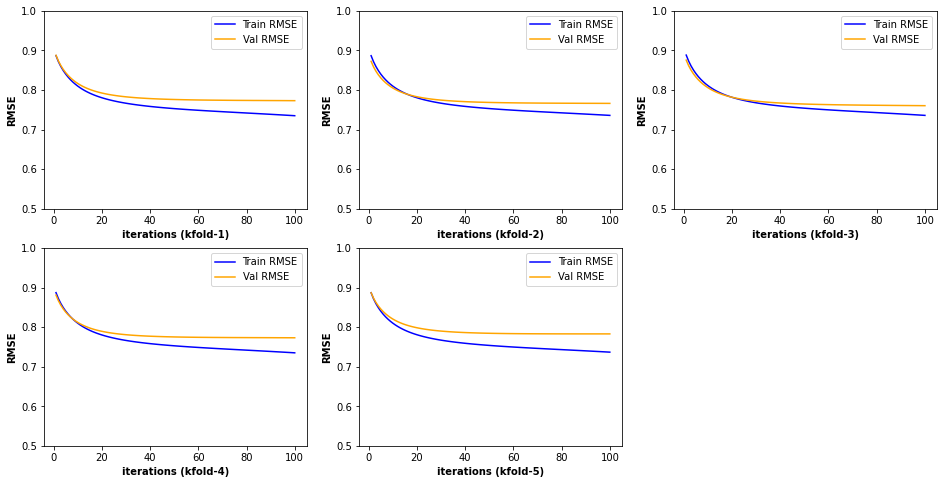

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], [result[1] for result in mf_result[idx]], color='blue', label='Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], [result[2] for result in mf_result[idx]], color='orange', label='Val RMSE')
      # ax[i, j].plot([x for x in range(1, 101)], [result[3] for result in mf_result[idx]], color='red', label='Test RMSE')

      ax[i, j].set_ylim(0.5, 1.0)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      ax[i, j].legend()
      idx += 1
    except IndexError:
      ax[i, j].set_visible(False)

plt.show()

In [ ]:
# 5번 KFOLD 결과 값 Plot 

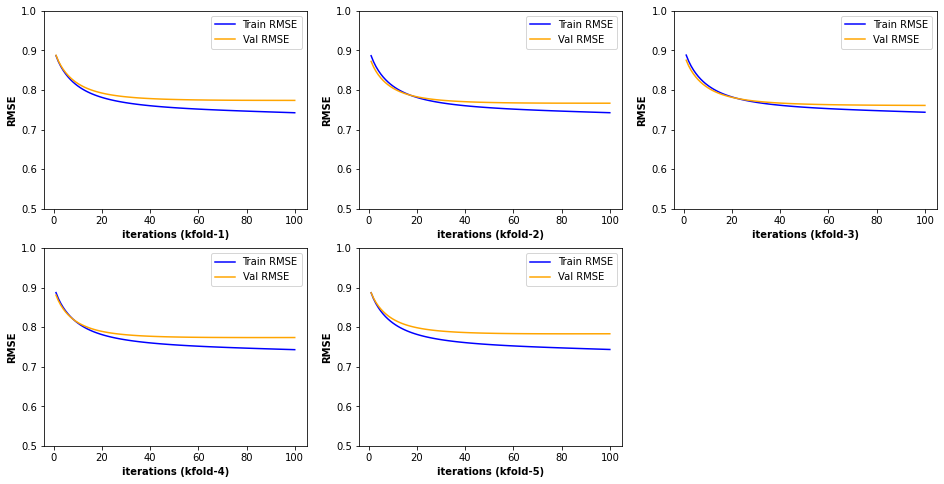

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], [result[1] for result in mf_k_result[idx]], color='blue', label='Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], [result[2] for result in mf_k_result[idx]], color='orange', label='Val RMSE')
      # ax[i, j].plot([x for x in range(1, 101)], [result[3] for result in mf_result[idx]], color='red', label='Test RMSE')
      ax[i, j].set_ylim(0.5, 1.0)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      ax[i, j].legend()
      idx += 1
    except IndexError:
       ax[i, j].set_visible(False)

plt.show()

In [ ]:
mf_ab_result

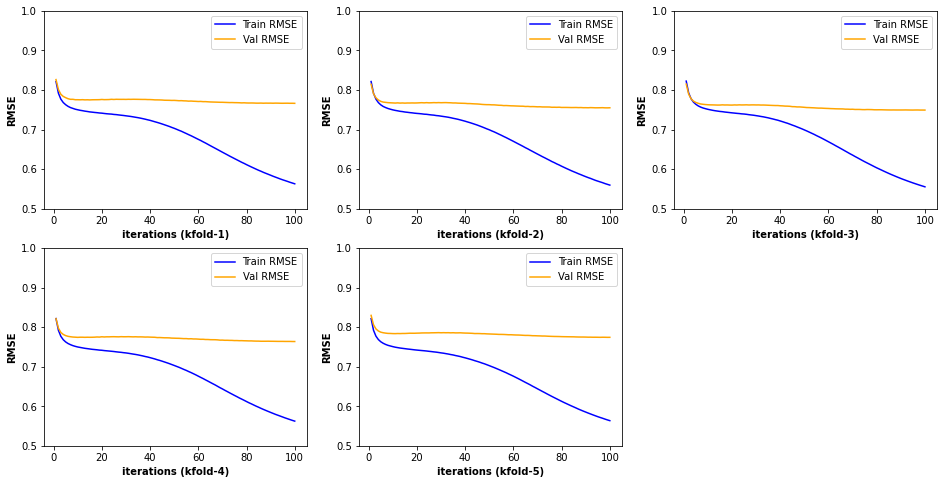

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], [result[1] for result in mf_ab_result[idx]], color='blue', label='Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], [result[2] for result in mf_ab_result[idx]], color='orange', label='Val RMSE')
      # ax[i, j].plot([x for x in range(1, 101)], [result[3] for result in mf_ab_result[idx]], color='red', label='Test RMSE')
      ax[i, j].set_ylim(0.5, 1.0)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      ax[i, j].legend()
      idx += 1
    except IndexError:
       ax[i, j].set_visible(False)

plt.show()

In [ ]:
a, b, c, d = zip(mf_ab_result[0], mf_ab_result[1], mf_ab_result[2], mf_ab_result[3], mf_ab_result[4])

ValueError: ignored

In [ ]:
val_rmse = 0 
for idx in range(5):
  for idx2 in range(100):
    val_rmse += mf_ab_result[idx][idx2][2]

val_rmse / 500

0.7694907977217621

In [ ]:
print(mf3.full_prediction())

[[4.45201014 5.16118291 5.15934579 ... 4.80721291 4.78400581 5.04344653]
 [3.93054336 4.60819733 4.66257726 ... 4.24447977 4.2420138  4.49859118]
 [3.81621503 4.48911395 4.55698819 ... 4.21234048 4.18595221 4.41372701]
 ...
 [4.51494683 5.1984228  5.2201481  ... 4.84285721 4.84464611 5.10564645]
 [2.97847696 3.66979    3.81596213 ... 3.30114292 3.34090101 3.5743575 ]
 [3.7402966  4.55386839 4.56415866 ... 4.05290446 4.01240316 4.29286483]]


In [ ]:
print(mf3.get_one_prediction(98380, 17984))   		

4.2530723969296345


In [ ]:
def convert_sent(point_list):
  list_p = []
  for idx, point in enumerate(point_list):
    if point > 3:
      list_p.append(0)
    else:
      list_p.append(1)
  print(len(list_p))
  return list_p

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix(model): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
c_matrix(mf)

20000
20000


,예측값(0),예측값(1)
실제값(0),16925,26
실제값(1),2888,161


In [ ]:
c_matrix(mf3)

20000
20000


,예측값(0),예측값(1)
실제값(0),16942,9
실제값(1),2526,523


In [ ]:
c_matrix(mf3)

20000
20000


,예측값(0),예측값(1)
실제값(0),16885,66
실제값(1),2874,175


In [ ]:
len(np.unique(datas[2][0]['goodsno']))

5699

In [ ]:
R_temp = dog_ratings.pivot(index='m_no', columns='goodsno', values='point').fillna(0)

mf3 = NEW_MF(R_temp, K=80, alpha=0.008, beta=0.1, iterations=100, verbose=True)   # MF 클래스 생성 
mf3.set_train_val(datas[2][0])
mf3.set_test(datas[2][1])
mf_result = mf3.test()

Iteration: 10; Training RMSE=0.7510; Val RMSE = 0.7626; Test RMSE = 0.7782
Iteration: 20; Training RMSE=0.7422; Val RMSE = 0.7619; Test RMSE = 0.7780
Iteration: 30; Training RMSE=0.7353; Val RMSE = 0.7621; Test RMSE = 0.7794
Iteration: 40; Training RMSE=0.7222; Val RMSE = 0.7602; Test RMSE = 0.7782
Iteration: 50; Training RMSE=0.6998; Val RMSE = 0.7562; Test RMSE = 0.7750
Iteration: 60; Training RMSE=0.6699; Val RMSE = 0.7530; Test RMSE = 0.7720
Iteration: 70; Training RMSE=0.6362; Val RMSE = 0.7512; Test RMSE = 0.7696
Iteration: 80; Training RMSE=0.6039; Val RMSE = 0.7499; Test RMSE = 0.7679
Iteration: 90; Training RMSE=0.5770; Val RMSE = 0.7495; Test RMSE = 0.7672
Iteration: 100; Training RMSE=0.5556; Val RMSE = 0.7489; Test RMSE = 0.7667


In [ ]:
id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
y_pred = np.array([mf3.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
# print(y_pred, type(y_pred))
y_pred = list(convert_sent(list(y_pred)))
y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 

print(classification_report(y_true, y_pred))

20000
20000
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     16951
           1       0.99      0.18      0.30      3049

    accuracy                           0.87     20000
   macro avg       0.93      0.59      0.61     20000
weighted avg       0.89      0.87      0.83     20000



In [ ]:
def recom_item(user_id, n_items):
  '''
  사용자 ID, 추천 아이템 수를 넘겨 받아 
  주어진 사용자에 대한 아이템을 추천해서 돌려주는 함수 
  '''
  user_item = R_temp.loc[user_id].copy()
  for item in R_temp:
    if user_item.loc[item] != 0:
      user_item.loc[item] = 0 
    else:
      user_item.loc[item] = mf3.get_one_prediction(user_id, item)
  
  item_sort = user_item.sort_values(ascending=False)[:n_items]
  recomm_items = dog_item.loc[item_sort.index]
  recommendations = recomm_items['goodsnm']
  return recommendations

recom_item(98380, 5)

goodsno
42047         코리아펫쇼 코펫 VIP 초청장 1매
56228           로얄캐닌 미니 스타터 8.5kg
20801     아일오브독스 로얄젤리 샴푸 NO.20 1L
6112              럭셔리독 양고기 캔 100g
82285    캐니대 독 그레인프리 퓨어씨 연어 5.4kg
Name: goodsnm, dtype: object

20000
20000
[2 1 0]


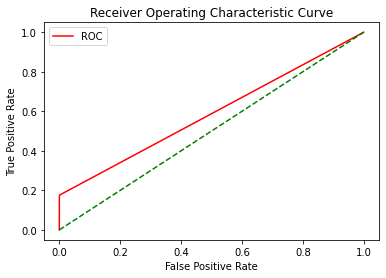

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(model):
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.get_one_prediction(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 

  fper, tper, thresholds = roc_curve(y_true, y_pred)

  print(thresholds)
  plt.plot(fper, tper, color='red', label='ROC')
  plt.plot([0, 1], [0, 1], color='green', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend()
  plt.show()

plot_roc_curve(mf3)

20000
20000
[2 1 0]


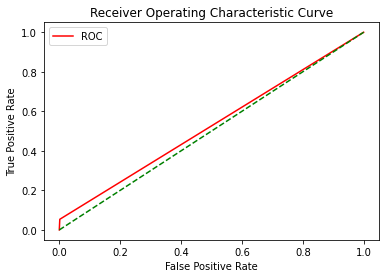

In [ ]:
plot_roc_curve(mf)